In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy.random as nrand
import math

from sklearn.datasets import load_iris
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


# Лабораторная работа 2.
«Наивный байесовский» классификатор.
## Задание.
1. Загрузить таблицу Mushroom из репозитория UCI (любого источника) в объект DataFrame.
Вычислить распределение значений категориальных признаков по классам (использовать pd.groupby).
Визуализировать распределения.
2. Построить решающую функцию по каждой переменной на основе частот. Вычислить точность каждого решения (на той же обучающей выборке). Найти наиболее информативную переменную (с минимальным числом ошибок).
3. Построить «наивный» байесовский классификатор из sklearn. Оценить точность. 
4. Самостоятельно реализовать метод, не используя готовый. Сравнить полученное решение с библиотечным. Добавить регуляризатор в оценки частот.
5. Применить метод логистической регрессии, использовав в качестве переменных оценки вероятностей, подвергнутые обратному логистическому преобразованию.


In [54]:
headers = [
    "class",                     # Класс (съедобный: 'e', ядовитый: 'p')
    "cap-shape",                 # Форма шляпки (bell: 'b', conical: 'c', convex: 'x', flat: 'f', knobbed: 'k', sunken: 's')
    "cap-surface",               # Поверхность шляпки (fibrous: 'f', grooves: 'g', scaly: 'y', smooth: 's')
    "cap-color",                 # Цвет шляпки
    "bruises",                   # Пятна (есть: 't', нет: 'f')
    "odor",                      # Запах
    "gill-attachment",           # Соединение жабер с ножкой (attached: 'a', descending: 'd', free: 'f', notched: 'n')
    "gill-spacing",              # Расстояние между жабрами (close: 'c', crowded: 'w', distant: 'd')
    "gill-size",                 # Размер жабер (broad: 'b', narrow: 'n')
    "gill-color",                # Цвет жабер
    "stalk-shape",               # Форма ножки (enlarging: 'e', tapering: 't')
    "stalk-root",                # Корень ножки (bulbous: 'b', club: 'c', cup: 'u', equal: 'e', rhizomorphs: 'z', rooted: 'r', missing: '?')
    "stalk-surface-above-ring",  # Поверхность ножки выше кольца (fibrous: 'f', scaly: 'y', silky: 'k', smooth: 's')
    "stalk-surface-below-ring",  # Поверхность ножки ниже кольца (fibrous: 'f', scaly: 'y', silky: 'k', smooth: 's')
    "stalk-color-above-ring",    # Цвет ножки выше кольца
    "stalk-color-below-ring",    # Цвет ножки ниже кольца
    "veil-type",                 # Тип вуали (partial: 'p', universal: 'u')
    "veil-color",                # Цвет вуали
    "ring-number",               # Количество колец (none: 'n', one: 'o', two: 't')
    "ring-type",                 # Тип кольца (cobwebby: 'c', evanescent: 'e', flaring: 'f', large: 'l', none: 'n', pendant: 'p', sheathing: 's', zone: 'z')
    "spore-print-color",         # Цвет спорового порошка
    "population",                # Популяция
    "habitat"                    # Среда обитания
]

# p, x, s, n, t, p.1, f, c, n.1, k, e, e.1, s.1, s.2, w, w.1, p.2, w.2, o, p.3, k.1, s.3, u

# Задание 1
Загрузить таблицу Mushroom из репозитория UCI (любого источника) в объект DataFrame.
Вычислить распределение значений категориальных признаков по классам (использовать pd.groupby).
Визуализировать распределения.


In [55]:
# df = pd.read_csv('./mushroom_data.csv')
# print(df.iloc[:0,:])

# Загрузка данных в DataFrame
df = pd.read_csv('./mushroom_data.csv', header=None)

# # Назначение имени столбцам
df.columns = headers
df.iloc[:5,:]

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [56]:
# Извлечение категориальных столбцов
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

# Инициализация пустого DataFrame для хранения распределения
distribution_by_class = pd.DataFrame(columns=['class'])

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')


Распределение значений категориальных признаков по классам представляет собой информацию о том, какие значения категориальных признаков встречаются в различных классах (группах) данных. Это позволяет понять, какие значения категориальных признаков характерны для каждого класса, и может быть полезно при анализе и прогнозировании данных.

простыми словами помагает нам понять какие признаки  важны для програзирования и какие могут быть информативными для решения задач классификации

  class     e     p    b  c     f    k   s     x     f  ...    s     v     y  \
e   NaN  4208     0  404  0  1596  228  32  1948  1560  ...  880  1192  1064   
p   NaN     0  3916   48  4  1556  600   0  1708   760  ...  368  2848   648   

      d     g    l    m     p    u    w  
e  1880  1408  240  256   136   96  192  
p  1268   740  592   36  1008  272    0  

[2 rows x 120 columns]


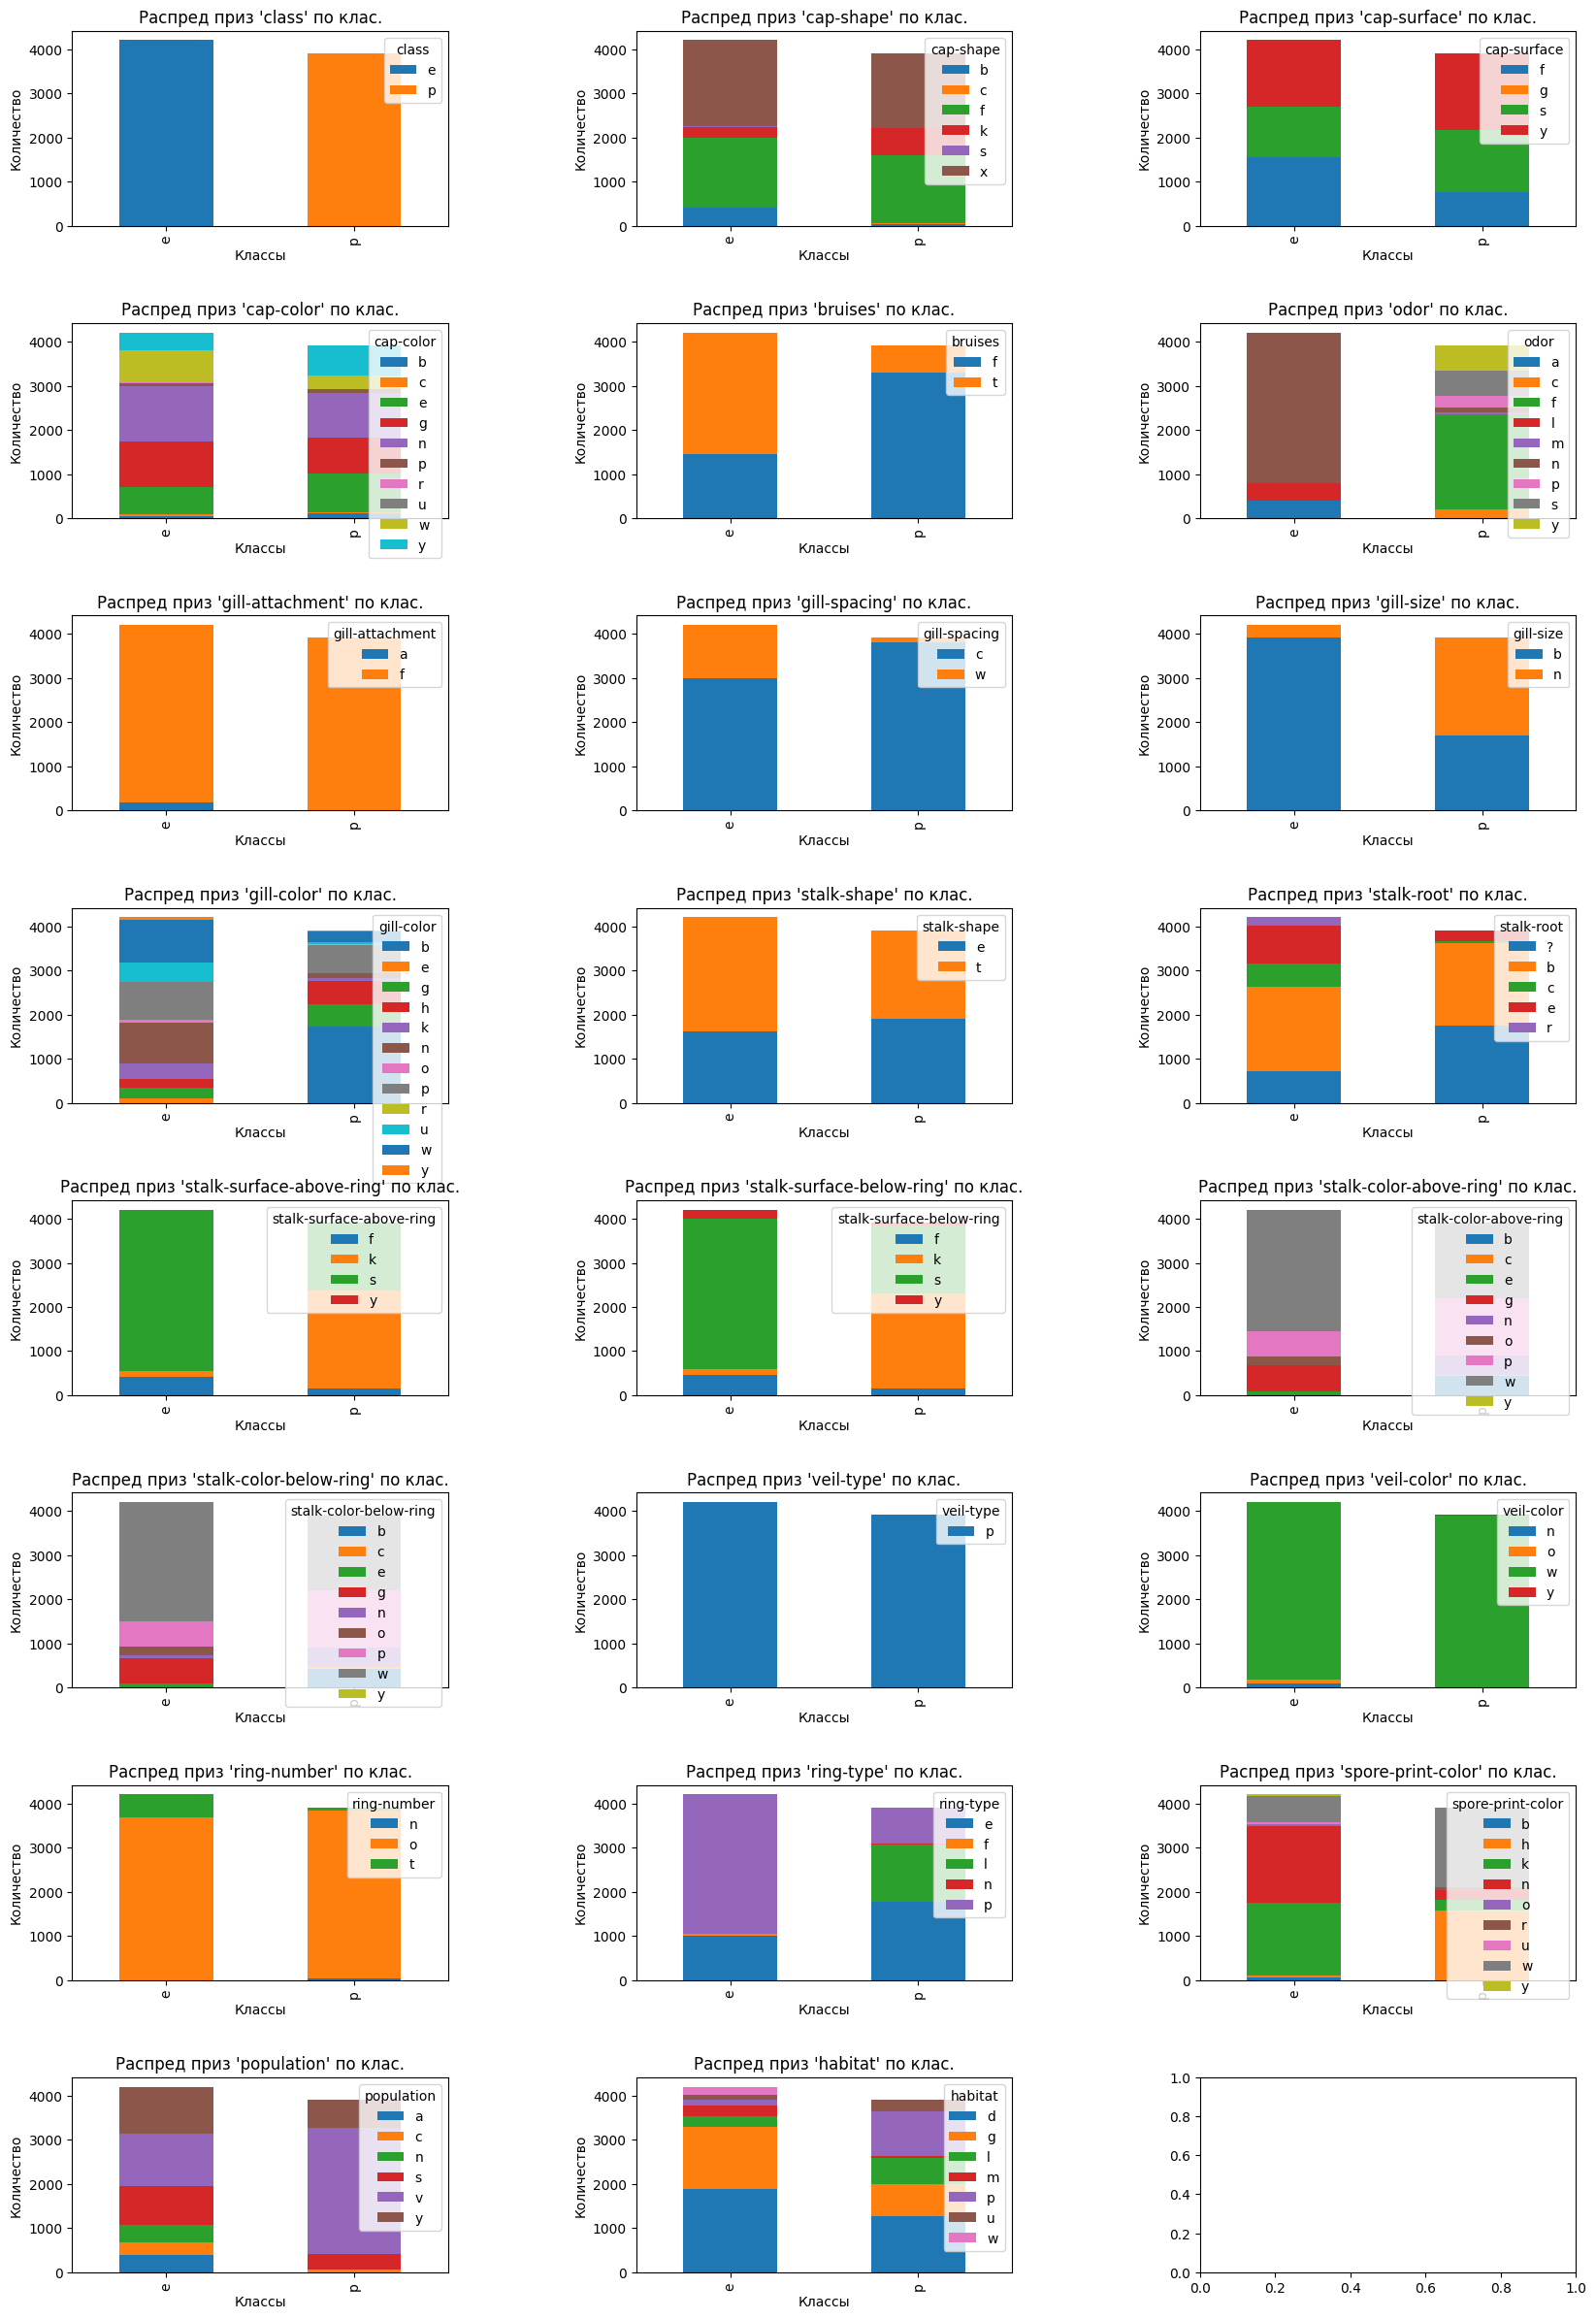

In [57]:
num_columns = 3
num_rows = math.ceil(len(headers) / num_columns)

# Создайте сетку графиков
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 30))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

i = 0

# Вычисление распределения для каждого категориального столбца
for feature  in categorical_columns:
    row = i // num_columns
    col = i % num_columns
    
    distribution = df.groupby(['class', feature]).size().unstack(fill_value=0)
    distribution_by_class = pd.concat([distribution_by_class, distribution], axis=1)

    # Визуализация распределения на подграфике
    distribution.plot(kind='bar', stacked=True, ax=axes[row, col])
    axes[row, col].set_title(f"Распред приз '{feature}' по клас.")
    axes[row, col].set_xlabel("Классы")
    axes[row, col].set_ylabel("Количество")
    axes[row, col].legend(title=feature, loc='upper right')

    i = i + 1

# Вывод распределения
print(distribution_by_class)

# Задание 2
### Построить решающую функцию по каждой переменной на основе частот. Вычислить точность каждого решения (на той же обучающей выборке). Найти наиболее информативную переменную (с минимальным числом ошибок).


Решающая функция - функцией, которая принимает на вход набор признаков объекта и возвращает предсказание относительно его принадлежности к одному из классов. Решающая функция определяет, какой класс будет назначен объекту на основе его признаков.

In [65]:
# Преобразование категориальных признаков в числа
le = LabelEncoder()
for col in df.columns:
    if col != 'class':
        df[col] = le.fit_transform(df[col])

# df.iloc[:5,:]

X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Решающая функция
def decision_function(x):
    # Расчитываю чистоты
    counts = X_train[y_train == 'e'][col].value_counts()
    return 'e' if x in counts.index and counts[x] > 0 else 'p'

# Построение решающей функции для каждого категориального признака и вычисление точности
accuracies = {}
most_info_variable = ""
most_acc = 0
for col in X_train.columns:
    # Примените решающую функцию к тестовой выборке
    y_pred = X_test[col].apply(decision_function)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[col] = accuracy
    
    if accuracy > most_acc:
        most_info_variable = col
        most_acc = accuracy

print("Точность решающей функции для каждой переменной:")
for col, accuracy in accuracies.items():
    print(f"{col}: {accuracy:.4f}")

print(f"\nНаиболее информативная переменная: {most_info_variable} {most_acc}")

Точность решающей функции для каждой переменной:
cap-shape: 0.5194
cap-surface: 0.5194
cap-color: 0.5188
bruises: 0.5188
odor: 0.9846
gill-attachment: 0.5188
gill-spacing: 0.5188
gill-size: 0.5188
gill-color: 0.7255
stalk-shape: 0.5188
stalk-root: 0.5188
stalk-surface-above-ring: 0.5188
stalk-surface-below-ring: 0.5188
stalk-color-above-ring: 0.5754
stalk-color-below-ring: 0.5785
veil-type: 0.5188
veil-color: 0.5194
ring-number: 0.5218
ring-type: 0.6868
spore-print-color: 0.5274
population: 0.5188
habitat: 0.5188

Наиболее информативная переменная: odor 0.9846153846153847


# Задание 3
## Построить «наивный» байесовский классификатор из sklearn. Оценить точность. 

Основан на теореме Байеса и считается "наивным", потому что делает упрощающее предположение о независимости признаков, что может быть не всегда справедливо в реальных данных. Его принцип

1 Собрание обучающего набора данных: Алгоритм требует обучающий набор данных, в котором для каждого объекта известны его признаки и соответствующий класс.

2 Вычисление априорных вероятностей классов: Для каждого класса вычисляются априорные вероятности P(Ci), то есть вероятности принадлежности объекта к каждому классу. Это можно сделать путем подсчета доли объектов, принадлежащих каждому классу, в обучающем наборе данных.

3 Вычисление условных вероятностей признаков для каждого класса: Для каждого признака вычисляются условные вероятности P(Xi|Ci), которые представляют собой вероятности того, что данный признак имеет конкретное значение, при условии, что объект принадлежит к классу Ci. Эти вероятности могут быть оценены на основе данных в обучающем наборе.

Применение теоремы Байеса: Для нового объекта с неизвестным классом вычисляются вероятности принадлежности к каждому классу на основе априорных вероятностей и условных вероятностей признаков. Это делается с использованием теоремы Байеса:

### P(Ci|X) = (P(X|Ci) * P(Ci)) / P(X)

Где:

 > P(Ci|X) - вероятность принадлежности к классу Ci при данном наблюдении X.

 > P(X|Ci) - условная вероятность наблюдения X при классе Ci (произведение условных вероятностей признаков).

 > P(Ci) - априорная вероятность класса Ci.
 
 > P(X) - общая вероятность наблюдения X (нормализующая константа).
Выбор класса: Алгоритм выбирает класс с наибольшей вероятностью, то есть класс, для которого P(Ci|X) максимальна.

Наивный байесовский классификатор обладает несколькими преимуществами:

Он эффективен и быстр в обучении и предсказаниях.
Может работать с большими объемами данных.
Хорошо справляется с текстовыми данными и задачами классификации текста.
Несмотря на свою наивность, он может давать хорошие результаты, особенно когда выполняются предположения о независимости признаков, и является хорошим выбором для начальной модели в задачах классификации.

---

"Получите бесплатное предложение!"
"Специальное предложение только сегодня!"
"Срочное сообщение от банка"
"Привет, как дела?"


1 Вычисление априорных вероятностей: 
P(Spam) = 2/4 = 0.5 (половина сообщений в обучающем наборе - спам)
P(Not Spam) = 2/4 = 0.5 (половина сообщений - не спам)

2 Вычисление условных вероятностей для каждого слова:
P("Получите" | Spam) = 1/2 = 0.5 (слово "Получите" встречается в 1 из 2 спам-сообщений)
P("бесплатное" | Spam) = 1/2 = 0.5
P("предложение" | Spam) = 2/2 = 1.0 (слово "предложение" встречается во всех спам-сообщениях)
P("Специальное" | Spam) = 1/2 = 0.5
P("только" | Spam) = 1/2 = 0.5
P("сегодня" | Spam) = 1/2 = 0.5
и так далее для всех слов

3 Вычисление условных вероятностей для каждого слова при неспаме:
P("Срочное" | Not Spam) = 0/2 = 0.0 (слово "Срочное" не встречается в неспам-сообщениях)
P("сообщение" | Not Spam) = 0/2 = 0.0
P("от" | Not Spam) = 0/2 = 0.0
P("банка" | Not Spam) = 1/2 = 0.5 (слово "банка" встречается в 1 из 2 неспам-сообщений)
P("Привет" | Not Spam) = 1/2 = 0.5
P("как" | Not Spam) = 1/2 = 0.5
P("дела" | Not Spam) = 1/2 = 0.5
и так далее для всех слов

4 Предсказание:
Теперь, если у нас есть новое сообщение, например, "Специальное предложение для вас!", мы можем вычислить вероятности для каждого класса и выбрать тот класс, который имеет наибольшую вероятность. Для этого сообщения:

P(Spam|Message) = P(Spam) * P("Специальное"|Spam) * P("предложение"|Spam) * P("для"|Spam) * P("вас!"|Spam)

P(Not Spam|Message) = P(Not Spam) * P("Специальное"|Not Spam) * P("предложение"|Not Spam) * P("для"|Not Spam) * P("вас!"|Not Spam)

Мы выбираем класс с наибольшей вероятностью (в данном случае, Spam), и сообщение классифицируется как "Спам".

In [72]:
from sklearn.naive_bayes import CategoricalNB
# Создаем и обучаем наивный байесовский классификатор
nb_classifier = CategoricalNB()
nb_classifier.fit(X_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = nb_classifier.predict(X_test)

# Оцениваем точность
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность наивного байесовского классификатора: {accuracy}\n\n\n")

Точность наивного байесовского классификатора: 0.9507692307692308





c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning:

# Задание 4
Самостоятельно реализовать метод, не используя готовый. Сравнить полученное решение с библиотечным. Добавить регуляризатор в оценки частот.

# Задание 5
Применить метод логистической регрессии, использовав в качестве переменных оценки вероятностей, подвергнутые обратному логистическому преобразованию.